In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, SeparableConv2D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.integration import TFKerasPruningCallback

# Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU:", physical_devices)
else:
    print("No GPU found. Using CPU instead.")

# Data parameters
base_dir = 'C:\\Users\\NickZografos\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT =  64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Function to load data
def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

# Load data
data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0  # Normalize the data

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

# Split data into training, validation, and test sets
train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define true labels for test set (used globally)
y_test_true = np.argmax(y_test, axis=1)

# Create data generator for data augmentation
def create_datagen(seed=None):
    return ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    ), seed

datagen, seed = create_datagen(seed=42)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=seed)
val_generator = datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, seed=seed)

# Compute class weights to handle data imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Define residual block
def residual_block(x, filters, kernel_size, use_batchnorm=True):
    shortcut = x
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        if use_batchnorm:
            shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define attention block
def attention_block(x, filters):
    attention = MultiHeadAttention(num_heads=8, key_dim=filters)(x, x)
    attention = Add()([x, attention])
    return attention

# Define the model structure
def build_model(trial, use_batchnorm=True):
    num_residual_blocks = trial.suggest_int('num_residual_blocks', 2, 5)
    filters = trial.suggest_int('filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dense_units = trial.suggest_int('dense_units', 512, 2048)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size, use_batchnorm=use_batchnorm)
        x = attention_block(x, filters)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna hyperparameter optimization
def objective(trial):
    model = build_model(trial, use_batchnorm=True)  # By default, use batch normalization
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=80,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, TFKerasPruningCallback(trial, 'val_loss')],
        verbose=1
    )
    
    val_accuracy = np.max(history.history['val_accuracy'])
    return val_accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=300)

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[I 2024-09-12 08:20:27,830] A new study created in memory with name: no-name-4e6705c1-d24f-4b26-8d62-00037fde5b7b


In [4]:
# BEST PARAMS FOUND IN ANOTHER TRIAL
#best_params = {'num_residual_blocks': 3, 'filters': 42, 'kernel_size': 4, 'dense_units': 1950, 'dropout_rate': 0.38009710985135164, 'learning_rate': 0.0007149894968299402}
#best_params

{'num_residual_blocks': 3,
 'filters': 42,
 'kernel_size': 4,
 'dense_units': 1950,
 'dropout_rate': 0.38009710985135164,
 'learning_rate': 0.0007149894968299402}

In [2]:
best_params = {'num_residual_blocks': 4, 'filters': 121, 'kernel_size': 5, 'dense_units': 1387, 'dropout_rate': 0.40846071442232423, 'learning_rate': 0.0002469909302048313}
best_params

{'num_residual_blocks': 4,
 'filters': 121,
 'kernel_size': 5,
 'dense_units': 1387,
 'dropout_rate': 0.40846071442232423,
 'learning_rate': 0.0002469909302048313}

In [4]:
# Print the best parameters
#best_params = study.best_params
print("Best parameters found: ", best_params)
#print("Best score: ", study.best_value)

# Build the best model from Optuna's results and fit it to get the history object
best_model = build_model(optuna.trial.FixedTrial(best_params))

# Train the best model on the full dataset
history = best_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=250,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)],
    verbose=1
)

# Evaluate the best model on the test set
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)

Best parameters found:  {'num_residual_blocks': 4, 'filters': 121, 'kernel_size': 5, 'dense_units': 1387, 'dropout_rate': 0.40846071442232423, 'learning_rate': 0.0002469909302048313}


C:\Users\NickZografos\AppData\Local\Temp\ipykernel_26136\3629006706.py:143: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/250
226/226 [==============================] - 52s 220ms/step - loss: 0.7493 - accuracy: 0.5206 - val_loss: 0.6916 - val_accuracy: 0.5844 - lr: 2.4699e-04
Epoch 2/250
226/226 [==============================] - 50s 220ms/step - loss: 0.6944 - accuracy: 0.5455 - val_loss: 0.6918 - val_accuracy: 0.5844 - lr: 2.4699e-04
Epoch 3/250
226/226 [==============================] - 50s 221ms/step - loss: 0.6808 - accuracy: 0.5611 - val_loss: 0.6938 - val_accuracy: 0.4549 - lr: 2.4699e-04
Epoch 4/250
226/226 [==============================] - 50s 222ms/step - loss: 0.6798 - accuracy: 0.5787 - val_loss: 0.6678 - val_accuracy: 0.6002 - lr: 2.4699e-04
Epoch 5/250
226/226 [==============================] - 50s 222ms/step - loss: 0.6744 - accuracy: 0.5797 - val_loss: 0.6761 - val_accuracy: 0.5844 - lr: 2.4699e-04
Epoch 6/250
226/226 [==============================] - 51s 223ms/step - loss: 0.6735 - accuracy: 0.5865 - val_loss: 0.7602 - val_accuracy: 0.5844 - lr: 2.4699e-04
Epoch 7/250
226/226 [=

In [5]:
# Ablation study configuration
ablation_configs = [
    {'name': 'Baseline', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Residual Blocks', 'no_residual_blocks': True, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Attention Blocks', 'no_residual_blocks': False, 'no_attention': True, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Dropout', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': True, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'Fixed Kernel Size', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': True, 'no_batchnorm': False},
    {'name': 'No Batch Normalization', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': True},
]

# Function to build ablation models
def build_ablation_model(ablation_config, best_params):
    num_residual_blocks = best_params['num_residual_blocks'] if not ablation_config.get('no_residual_blocks') else 0
    filters = best_params['filters']
    kernel_size = best_params['kernel_size'] if not ablation_config.get('no_kernel_size_variation') else 3
    dense_units = best_params['dense_units']
    dropout_rate = best_params['dropout_rate'] if not ablation_config.get('no_dropout') else 0.0
    learning_rate = best_params['learning_rate']
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size, use_batchnorm=not ablation_config.get('no_batchnorm'))
        if not ablation_config.get('no_attention'):
            x = attention_block(x, filters)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(dense_units, activation='relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to gather performance metrics for ablation models
def ablation_study(best_params, ablation_configs):
    ablation_results = []
    for config in ablation_configs:
        print(f"Training Ablation Model: {config['name']}")
        ablation_model = build_ablation_model(config, best_params)
        
        history = ablation_model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=200,
            validation_data=val_generator,
            class_weight=class_weights,
            verbose=1
        )

        # Evaluate on test set
        test_loss, test_accuracy = ablation_model.evaluate(X_test, y_test, verbose=0)
        test_predictions = ablation_model.predict(X_test)
        y_test_pred_ablation = np.argmax(test_predictions, axis=1)
        conf_matrix = confusion_matrix(y_test_true, y_test_pred_ablation)
        
        precision = precision_score(y_test_true, y_test_pred_ablation, average='weighted')
        recall = recall_score(y_test_true, y_test_pred_ablation, average='weighted')
        f1 = f1_score(y_test_true, y_test_pred_ablation, average='weighted')

        # Append results
        ablation_results.append({
            'Configuration': config['name'],
            'Test Accuracy': test_accuracy,
            'Test Loss': test_loss,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Confusion Matrix Plot
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f'Confusion Matrix - {config["name"]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Accuracy and Loss Plot
        plt.plot(history.history['loss'], label=f'{config["name"]} - Train Loss')
        plt.plot(history.history['val_loss'], label=f'{config["name"]} - Val Loss')
        plt.title(f'Loss Comparison - {config["name"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Create a DataFrame for the ablation results
    ablation_results_df = pd.DataFrame(ablation_results)
    ablation_results_df.to_excel('ablation_study_results.xlsx', index=False)
    print("Ablation study results saved to 'ablation_study_results.xlsx'.")
    return ablation_results_df



Training Ablation Model: Baseline
Epoch 1/200
226/226 [==============================] - 54s 227ms/step - loss: 0.7599 - accuracy: 0.5288 - val_loss: 0.6937 - val_accuracy: 0.4189
Epoch 2/200
226/226 [==============================] - 51s 225ms/step - loss: 0.6957 - accuracy: 0.5484 - val_loss: 0.6868 - val_accuracy: 0.5844
Epoch 3/200
226/226 [==============================] - 51s 227ms/step - loss: 0.6869 - accuracy: 0.5574 - val_loss: 0.6753 - val_accuracy: 0.5803
Epoch 4/200
226/226 [==============================] - 51s 227ms/step - loss: 0.6802 - accuracy: 0.5690 - val_loss: 0.6667 - val_accuracy: 0.5981
Epoch 5/200
226/226 [==============================] - 52s 228ms/step - loss: 0.6756 - accuracy: 0.5751 - val_loss: 0.6896 - val_accuracy: 0.6093
Epoch 6/200
226/226 [==============================] - 52s 228ms/step - loss: 0.6724 - accuracy: 0.5902 - val_loss: 0.6655 - val_accuracy: 0.5969
Epoch 7/200
226/226 [==============================] - 51s 227ms/step - loss: 0.6726 - acc

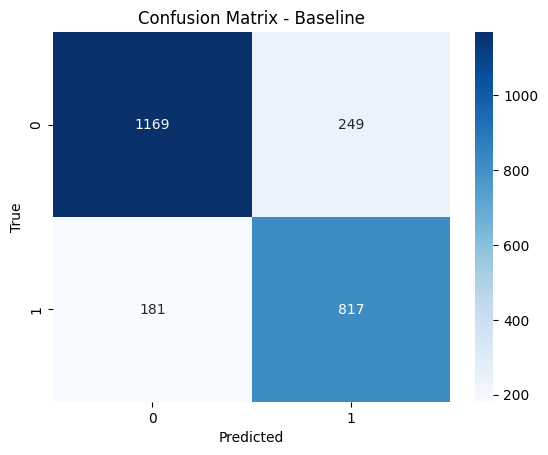

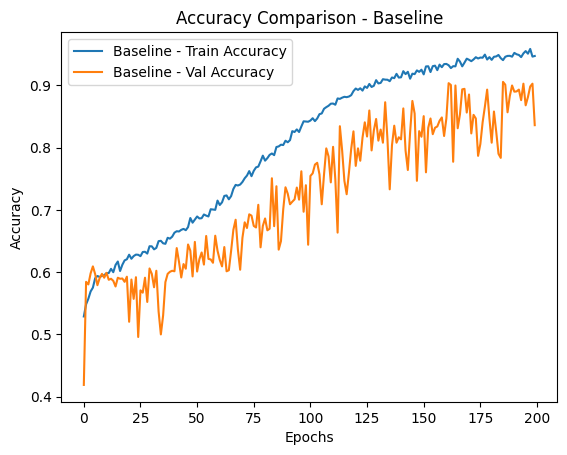

Training Ablation Model: No Residual Blocks
Epoch 1/200
226/226 [==============================] - 12s 53ms/step - loss: 0.6931 - accuracy: 0.4807 - val_loss: 0.6830 - val_accuracy: 0.5844
Epoch 2/200
226/226 [==============================] - 11s 49ms/step - loss: 0.6928 - accuracy: 0.5064 - val_loss: 0.7007 - val_accuracy: 0.4151
Epoch 3/200
226/226 [==============================] - 13s 56ms/step - loss: 0.6914 - accuracy: 0.5175 - val_loss: 0.6826 - val_accuracy: 0.5865
Epoch 4/200
226/226 [==============================] - 10s 43ms/step - loss: 0.6910 - accuracy: 0.5218 - val_loss: 0.6884 - val_accuracy: 0.5600
Epoch 5/200
226/226 [==============================] - 11s 49ms/step - loss: 0.6887 - accuracy: 0.5484 - val_loss: 0.6813 - val_accuracy: 0.5948
Epoch 6/200
226/226 [==============================] - 13s 59ms/step - loss: 0.6869 - accuracy: 0.5485 - val_loss: 0.6770 - val_accuracy: 0.5944
Epoch 7/200
226/226 [==============================] - 9s 41ms/step - loss: 0.6870 - a

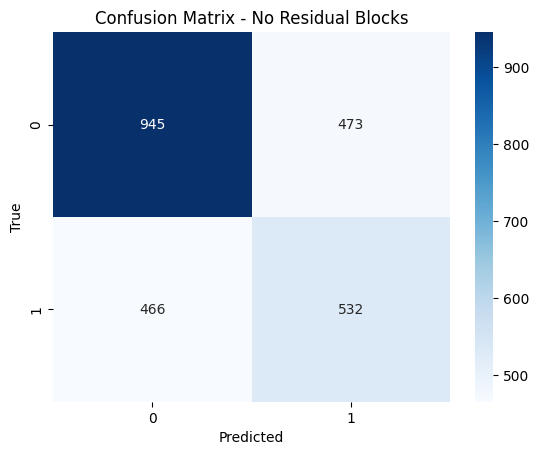

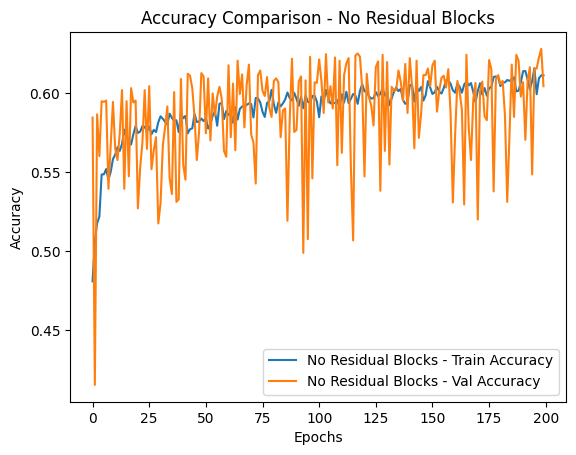

Training Ablation Model: No Attention Blocks
Epoch 1/200
226/226 [==============================] - 11s 43ms/step - loss: 0.7932 - accuracy: 0.5288 - val_loss: 0.6883 - val_accuracy: 0.5844
Epoch 2/200
226/226 [==============================] - 11s 49ms/step - loss: 0.7077 - accuracy: 0.5527 - val_loss: 0.6835 - val_accuracy: 0.5844
Epoch 3/200
226/226 [==============================] - 9s 41ms/step - loss: 0.6918 - accuracy: 0.5539 - val_loss: 0.6815 - val_accuracy: 0.5861
Epoch 4/200
226/226 [==============================] - 11s 50ms/step - loss: 0.6825 - accuracy: 0.5639 - val_loss: 0.6901 - val_accuracy: 0.5786
Epoch 5/200
226/226 [==============================] - 10s 42ms/step - loss: 0.6784 - accuracy: 0.5802 - val_loss: 0.6711 - val_accuracy: 0.5902
Epoch 6/200
226/226 [==============================] - 10s 44ms/step - loss: 0.6765 - accuracy: 0.5773 - val_loss: 0.7116 - val_accuracy: 0.5124
Epoch 7/200
226/226 [==============================] - 12s 53ms/step - loss: 0.6719 - 

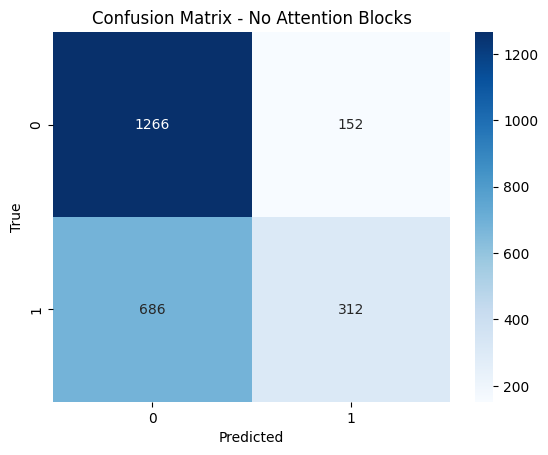

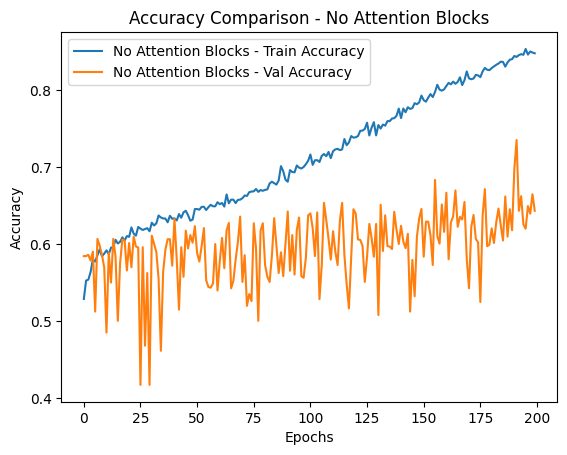

Training Ablation Model: No Dropout
Epoch 1/200
226/226 [==============================] - 54s 225ms/step - loss: 0.7239 - accuracy: 0.5281 - val_loss: 0.6933 - val_accuracy: 0.4603
Epoch 2/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6916 - accuracy: 0.5563 - val_loss: 0.6844 - val_accuracy: 0.5844
Epoch 3/200
226/226 [==============================] - 52s 231ms/step - loss: 0.6814 - accuracy: 0.5671 - val_loss: 0.6867 - val_accuracy: 0.5724
Epoch 4/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6781 - accuracy: 0.5741 - val_loss: 0.8164 - val_accuracy: 0.4156
Epoch 5/200
226/226 [==============================] - 51s 225ms/step - loss: 0.6725 - accuracy: 0.5837 - val_loss: 0.7081 - val_accuracy: 0.5803
Epoch 6/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6723 - accuracy: 0.5942 - val_loss: 0.6869 - val_accuracy: 0.5849
Epoch 7/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6713 - a

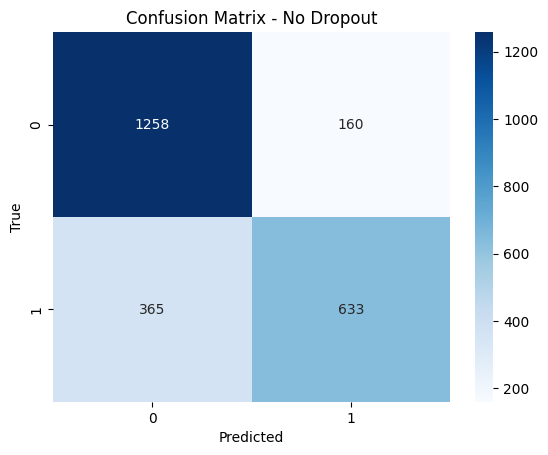

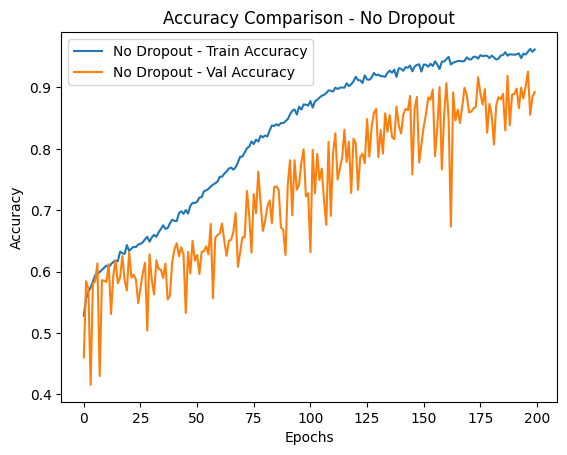

Training Ablation Model: Fixed Kernel Size
Epoch 1/200
226/226 [==============================] - 55s 225ms/step - loss: 0.7565 - accuracy: 0.5187 - val_loss: 0.6917 - val_accuracy: 0.5844
Epoch 2/200
226/226 [==============================] - 51s 225ms/step - loss: 0.6925 - accuracy: 0.5597 - val_loss: 0.6828 - val_accuracy: 0.5844
Epoch 3/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6789 - accuracy: 0.5707 - val_loss: 0.6935 - val_accuracy: 0.5054
Epoch 4/200
226/226 [==============================] - 51s 225ms/step - loss: 0.6765 - accuracy: 0.5856 - val_loss: 0.8266 - val_accuracy: 0.4474
Epoch 5/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6744 - accuracy: 0.5940 - val_loss: 0.7587 - val_accuracy: 0.5844
Epoch 6/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6758 - accuracy: 0.5915 - val_loss: 0.6929 - val_accuracy: 0.5844
Epoch 7/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6

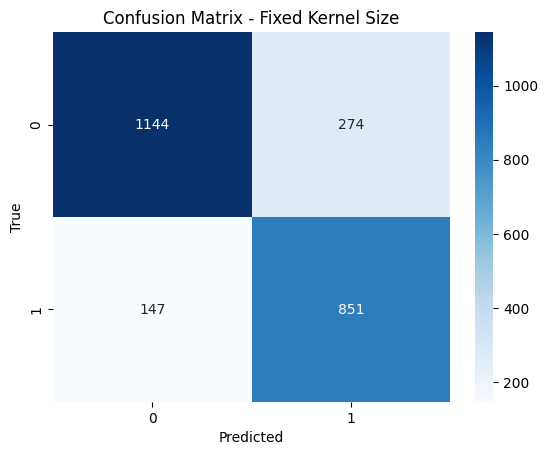

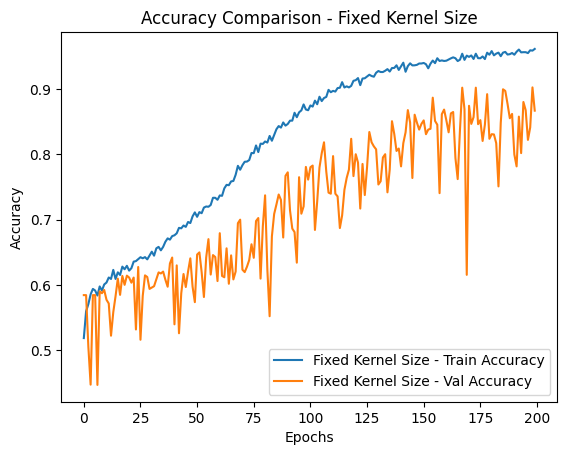

Training Ablation Model: No Batch Normalization
Epoch 1/200
226/226 [==============================] - 53s 223ms/step - loss: 0.6947 - accuracy: 0.5010 - val_loss: 0.6947 - val_accuracy: 0.4156
Epoch 2/200
226/226 [==============================] - 50s 221ms/step - loss: 0.6939 - accuracy: 0.4792 - val_loss: 0.6858 - val_accuracy: 0.5844
Epoch 3/200
226/226 [==============================] - 50s 221ms/step - loss: 0.6937 - accuracy: 0.5087 - val_loss: 0.6938 - val_accuracy: 0.4156
Epoch 4/200
226/226 [==============================] - 50s 221ms/step - loss: 0.6935 - accuracy: 0.5037 - val_loss: 0.6944 - val_accuracy: 0.4156
Epoch 5/200
226/226 [==============================] - 50s 221ms/step - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6856 - val_accuracy: 0.5844
Epoch 6/200
226/226 [==============================] - 50s 221ms/step - loss: 0.6933 - accuracy: 0.5173 - val_loss: 0.6894 - val_accuracy: 0.5844
Epoch 7/200
226/226 [==============================] - 50s 220ms/step - loss

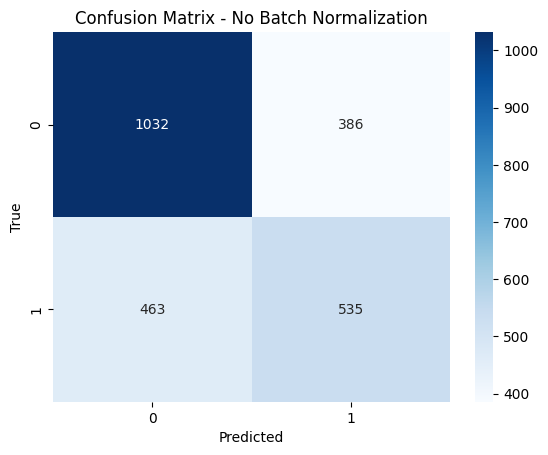

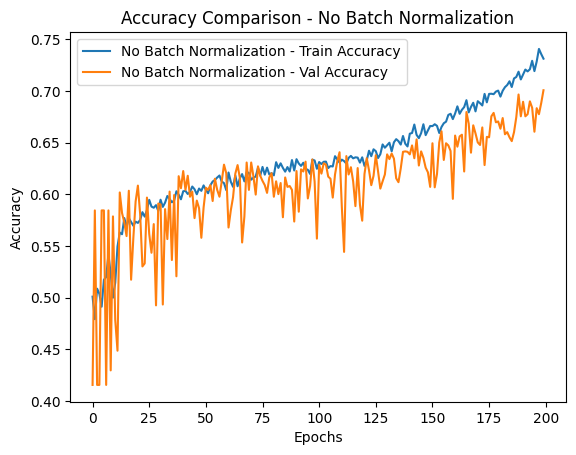

Ablation study results saved to 'ablation_study_results.xlsx'.
Full study results (including ablation) saved to 'full_study_results.xlsx'.
Additional statistical tables saved.


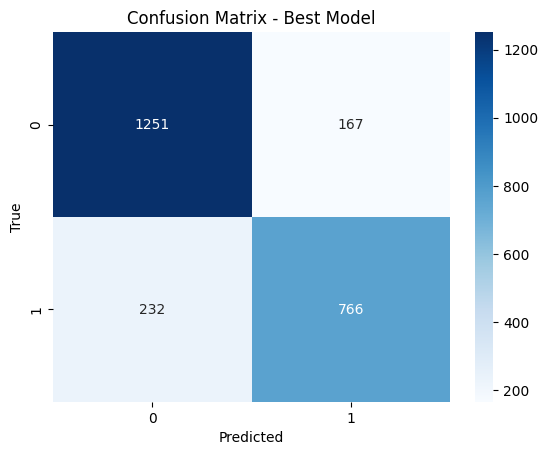

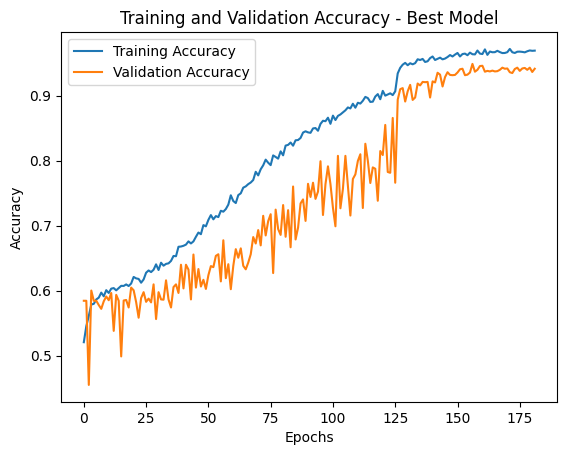

Additional visualizations saved.


In [6]:
# Perform the ablation study
ablation_results_df = ablation_study(best_params, ablation_configs)

# Combine and save full results including Optuna best model
optuna_best_results = {
    'Configuration': 'Best Model (Optuna)',
    'Test Accuracy': np.max(history.history['val_accuracy']),
    'Test Loss': np.min(history.history['val_loss']),
    'Precision': precision_score(y_test_true, y_test_pred, average='weighted'),
    'Recall': recall_score(y_test_true, y_test_pred, average='weighted'),
    'F1 Score': f1_score(y_test_true, y_test_pred, average='weighted')
}

# Convert Optuna best results to a DataFrame and concatenate with ablation results
optuna_best_results_df = pd.DataFrame([optuna_best_results])
final_results = pd.concat([ablation_results_df, optuna_best_results_df], ignore_index=True)

# Save the full study results to Excel
final_results.to_excel('full_study_results.xlsx', index=False)
print("Full study results (including ablation) saved to 'full_study_results.xlsx'.")

# Save additional statistical tables to .xlsx format
def save_additional_statistics():
    # Table 1: Summary of the hyperparameters for the best model
    best_params_df = pd.DataFrame([best_params])
    best_params_df.to_excel('best_model_hyperparameters.xlsx', index=False)
    
    # Table 2: Training and Validation Accuracy Over Epochs for the Best Model
    accuracy_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['accuracy']) + 1),
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy']
    })
    accuracy_df.to_excel('training_validation_accuracy.xlsx', index=False)
    
    # Table 3: Training and Validation Loss Over Epochs for the Best Model
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })
    loss_df.to_excel('training_validation_loss.xlsx', index=False)
    
    # Other tables based on ablation study results and model performance metrics can be added similarly
    print("Additional statistical tables saved.")

save_additional_statistics()

# Create and save additional visualizations
def save_visualizations():
    # Plot 1: Confusion Matrix for the Best Model
    conf_matrix_best = confusion_matrix(y_test_true, y_test_pred)
    sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix - Best Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix_best_model.png')
    plt.show()
    
    # Plot 2: Training and Validation Accuracy Plot for the Best Model
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - Best Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot_best_model.png')
    plt.show()
    
    # Other plots based on training and ablation study can be generated similarly
    print("Additional visualizations saved.")

save_visualizations()